In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Practical 2: Classification

## Introduction

In this practical, 
we are going to build on the methods learned in the previous session on *linear regression*.

The following datasets have been prepared:

- **Labels**: CORINE land cover map for the year 2018 (44 land cover classes), for an area around Naples, Italy
- **Data**:
    - a (mostly) cloud-free Sentinel-2 mosaic with 10 spectral bands
    - Sentinel-1 images in two polarisations (VH, VV) and two orbit directions (asc, desc) for winter, spring, summer, and autumn (16 total features)

We will keep using `scikit-learn` for classification, which in this library works analogously to regression.
We will also use the `xarray` library for working with NetCDF files.

In addition, for an easier integration of `scikit-learn` with `xarray`,
I am using the library `nd` which is available from PyPI:

```
pip install nd
```

## Class labels

**CORINE Land Cover:**
https://land.copernicus.eu/pan-european/corine-land-cover/clc2018?tab=mapview

In [2]:
labels = xr.open_dataarray('data/corine_labels.nc')

In [3]:
legend = pd.read_csv('data/corine_legend.csv', index_col=0)
legend = legend.set_index('CLC_CODE')

In [4]:
legend

,GRID_CODE,LABEL3,RGB,R,G,B
CLC_CODE,,,,,,
111,1,Continuous urban fabric,230-000-077,230.0,0.0,77.0
112,2,Discontinuous urban fabric,255-000-000,255.0,0.0,0.0
121,3,Industrial or commercial units,204-077-242,204.0,77.0,242.0
122,4,Road and rail networks and associated land,204-000-000,204.0,0.0,0.0
123,5,Port areas,230-204-204,230.0,204.0,204.0
124,6,Airports,230-204-230,230.0,204.0,230.0
131,7,Mineral extraction sites,166-000-204,166.0,0.0,204.0
132,8,Dump sites,166-077-000,166.0,77.0,0.0
133,9,Construction sites,255-077-255,255.0,77.0,255.0


In [5]:
def make_rgb(labels):
    lut = legend[['R', 'G', 'B']].to_xarray() / 255
    return lut.sel(CLC_CODE=labels).to_array('rgb')

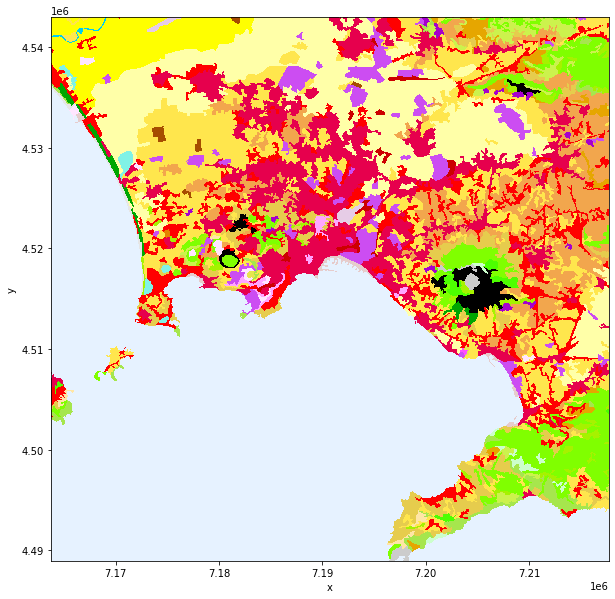

In [6]:
rgb = make_rgb(labels)
rgb.plot.imshow(rgb='rgb', figsize=(10, 10))

### Visualize legend

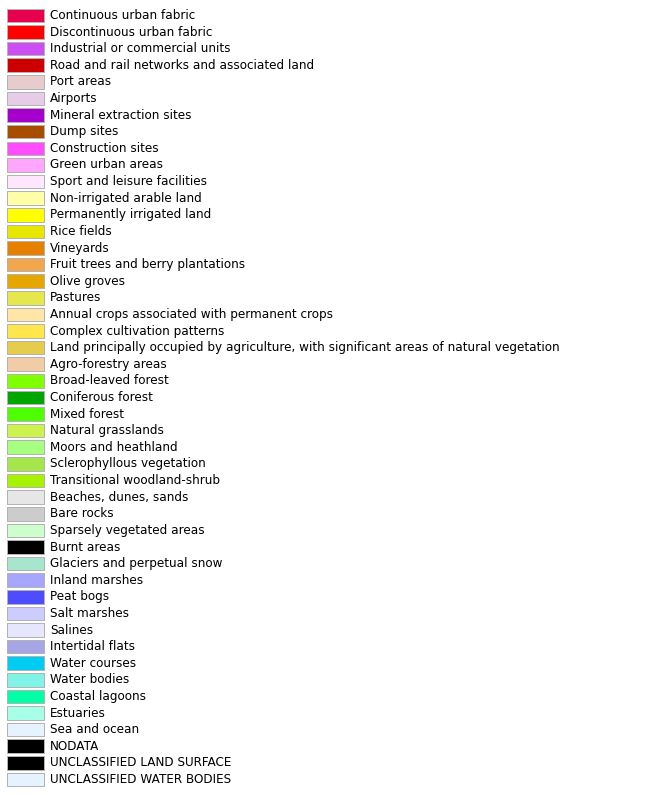

In [7]:
from matplotlib.patches import Rectangle
colors = dict(zip(legend['LABEL3'], legend[['R', 'G', 'B']].values/255))
N = len(colors)

cell_width = 212
cell_height = 22
swatch_width = 48
dpi = 72

fig, ax = plt.subplots(figsize=(cell_width * 4 / dpi, cell_height * N / dpi), dpi=dpi)
ax.set_xlim(0, cell_width * 4)
ax.set_ylim(cell_height * (N-0.5), -cell_height/2.)
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_axis_off()
for i, (name, color) in enumerate(colors.items()):
    y = i * cell_height
    ax.text(swatch_width + 7, y, name, fontsize=12, ha='left', va='center')
    ax.add_patch(
        Rectangle(xy=(0, y-9), width=swatch_width,
                  height=18, facecolor=colors[name], edgecolor='0.7'))
    

# Open data

In [8]:
data = xr.open_dataset('data/naples.nc')

In [9]:
data

<xarray.Dataset>
Dimensions:         (y: 1800, x: 1800)
Coordinates:
    lat             (y, x) float64 ...
    lon             (y, x) float64 ...
  * x               (x) float64 7.164e+06 7.164e+06 ... 7.218e+06 7.218e+06
  * y               (y) float64 4.543e+06 4.543e+06 ... 4.489e+06 4.489e+06
Data variables: (12/26)
    B1              (y, x) float32 ...
    B11             (y, x) float32 ...
    B12             (y, x) float32 ...
    B2              (y, x) float32 ...
    B3              (y, x) float32 ...
    B4              (y, x) float32 ...
    ...              ...
    VV_asc_summer   (y, x) float32 ...
    VV_asc_winter   (y, x) float32 ...
    VV_desc_autumn  (y, x) float32 ...
    VV_desc_spring  (y, x) float32 ...
    VV_desc_summer  (y, x) float32 ...
    VV_desc_winter  (y, x) float32 ...
Attributes:
    transform:                 [ 3.00000000e+01  0.00000000e+00  7.16370106e+...
    crs:                       EPSG:7794
    res:                       [0.00017966 0.00017966]
    is_tiled:                  1
    nodatavals:                [nan nan]
    scales:                    [1. 1.]
    offsets:                   [0. 0.]
    AREA_OR_POINT:             Area
    coordinate_system_string:  PROJCS["RDN2008 / Italy zone (E-N)",GEOGCS["RD...
    lines:                     1909
    samples:                   2297

### Sentinel-1: [VV, VH, VV/VH] RGB Composite

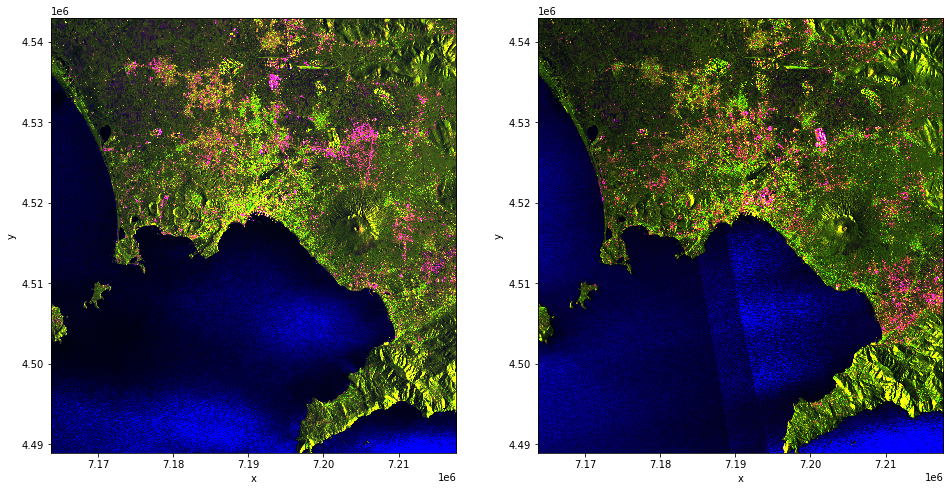

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i, tag in enumerate(['desc_summer', 'asc_summer']):
    s1_rgb = xr.concat([
        data[f'VV_{tag}'], data[f'VH_{tag}'], data[f'VV_{tag}']/data[f'VH_{tag}']
    ], dim='rgb')
    s1_rgb /= s1_rgb.mean(('x', 'y'))
    s1_rgb.plot.imshow(rgb='rgb', ax=ax[i], robust=True)

### Sentinel-2: RGB Composite

Text(0.5, 1.0, 'False color composite')

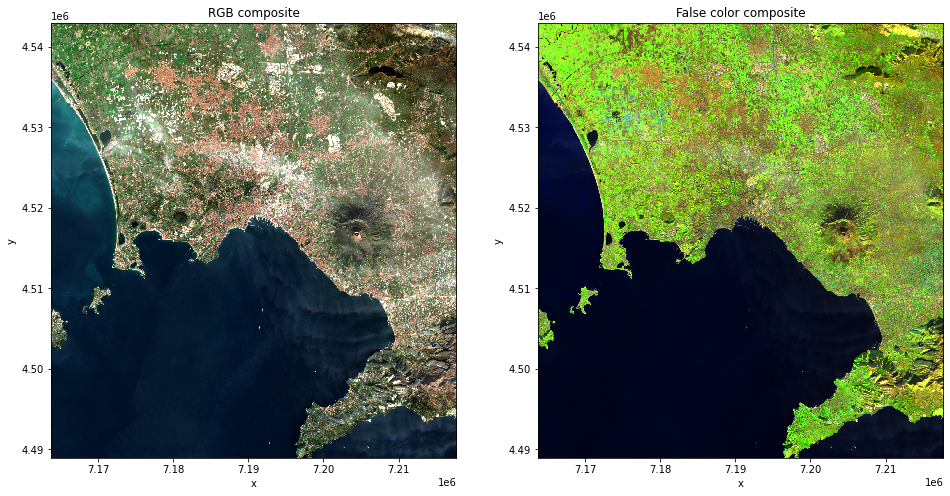

In [11]:
rgb = data[['B4', 'B3', 'B2']].to_array('rgb')
swir = data[['B11', 'B8', 'B2']].to_array('rgb')
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
rgb.plot.imshow(rgb='rgb', ax=ax[0], robust=True)
swir.plot.imshow(rgb='rgb', ax=ax[1], robust=True)
ax[0].set_title('RGB composite')
ax[1].set_title('False color composite')

## Binary Classification

We are now going to look at binary classification to begin with.
Many classification algorithms are designed to work with only two classes.
For the data provided here, we have a total of 44 different labels,
and so we will create a new set of labels by grouping the existing labels into *urban* and *non-urban*.

Labels with a code under 200 correspond to urban/built-up areas.
Zeros are considered NaN, so add 1:

In [12]:
urban = (labels < 200).astype(int) + 1

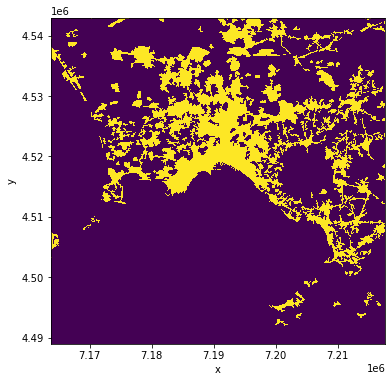

In [13]:
plt.figure(figsize=(6, 6))
urban.plot(add_colorbar=False)

## Overfitting demonstration

As a demonstration what happens if we don't carefully think about what we are doing,
let's looks at fitting a simple decision tree to some of our data.

In [14]:
import nd
import nd.classify
from sklearn.tree import DecisionTreeClassifier

In [15]:
_c = DecisionTreeClassifier(max_depth=30)
tree = nd.classify.Classifier(_c)

In [16]:
mask = np.zeros_like(urban)
mask[1000:1400, 1400:1800] = 1
# sampled = sample(area.shape, N=10000)
# area[sampled] = 1
train1 = urban.where(mask)

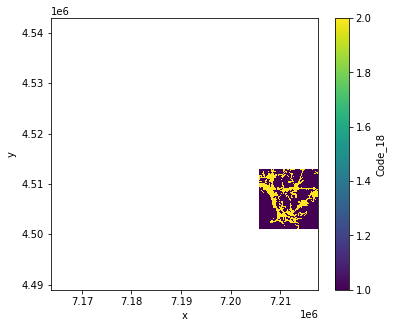

In [17]:
plt.figure(figsize=(6, 5))
urban.where(mask).plot(rasterized=True)

Assemble data

In [18]:
%time tree.fit(data, train1)

CPU times: user 8.13 s, sys: 428 ms, total: 8.56 s
Wall time: 8.57 s


In [19]:
%time pred_tree = tree.predict(data).transpose('y', 'x')

CPU times: user 1.35 s, sys: 347 ms, total: 1.7 s
Wall time: 1.7 s


If we plot the results,
we can see that our classifier works very well in the area that was used for training,
but not very well at all in the other areas.

This is called overfitting and must be avoided.

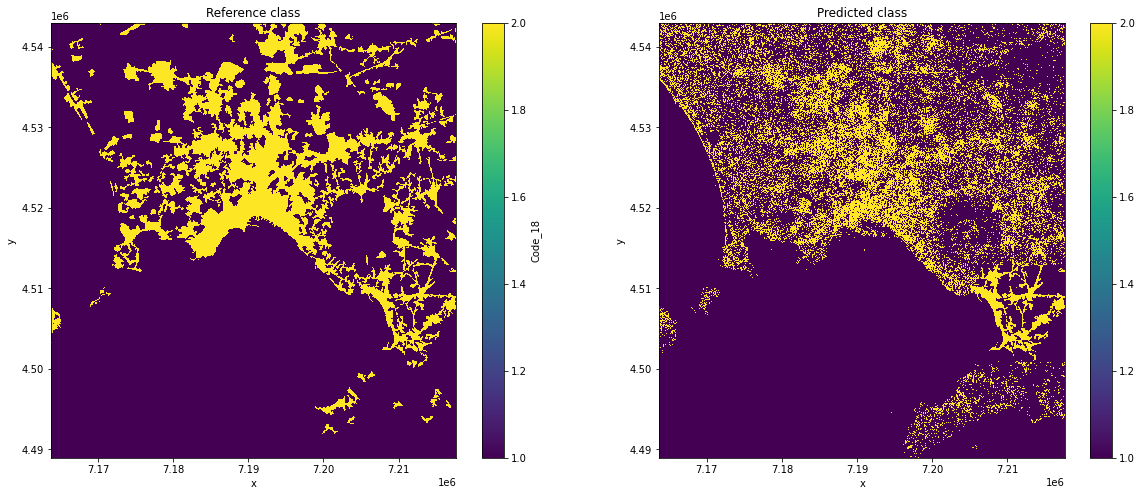

In [20]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
urban.plot(ax=ax[0])
ax[0].set_title('Reference class')
pred_tree.plot(ax=ax[1])
ax[1].set_title('Predicted class');

## Logistic regression

Let's try again, this time using a logistic regression classifier.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Preprocessing

In general, most data will require some form of preprocessing before classification.

This could include

- dealing with missing data (imputation)
- encoding categorical variables
- scaling
- dimensionality reduction

In fact, in most real-life classification problems, pre-processing takes up the majority of the time and effort.
This is because real-life data is not in general well-behaved and we have to deal with
missing, noisy or corrupted data,
unconventional data and file formats,
different data sources, mismatched sampling frequencies,
and different data types (floating point, integer, boolean, categorical, etc).

More details: https://scikit-learn.org/stable/modules/preprocessing.html

In this case, most of the pre-processing has already been done:
there is no missing data and all variables have been resampled to exactly the same grid,
and aligned with the reference data.

In `scikit-learn`, preprocessing and classification steps can be conveniently chained together in a so-called *pipeline*.
We will demonstrate this in the following by applying a standard scaler to the data before classification using logistic regression.

In general, 
scaling is required for classification algorithms that are sensitive to
the relative magnitudes of different variables/features.
For example, scaling will have no effect for a decision tree classifier,
because the decision thresholds are decided independently for each feature.
However, in logistic regression,
the feature importance is influenced by their magnitude and so it is important
to transform all variables to the same scale
so we don't introduce any bias.

Here is a small helper function that lets us create a random sample of `N` points:

In [22]:
def sample(shape, N):
    size = np.product(shape)
    idx = np.random.choice(np.arange(size), size=N, replace=False)
    sample = np.zeros(size, dtype=bool)
    sample[idx] = True
    sample = sample.reshape(shape)
    return sample

Using the helper function, we create a sample of 10000 points for training.

In [23]:
mask = sample(urban.shape, N=10000)
train2 = urban.where(mask)

We now create a pipeline consisting of a `StandardScaler` and a `LogisticRegression`.

In [24]:
_c = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('logistic', LogisticRegression())
])
logistic = nd.classify.Classifier(_c)

In [25]:
%time logistic.fit(data, train2)

CPU times: user 1.71 s, sys: 247 ms, total: 1.95 s
Wall time: 1.07 s


/Users/jhansen/anaconda3/envs/sense4/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
%time pred_logistic = logistic.predict(data).transpose('y', 'x')

CPU times: user 4.93 s, sys: 892 ms, total: 5.83 s
Wall time: 2.35 s


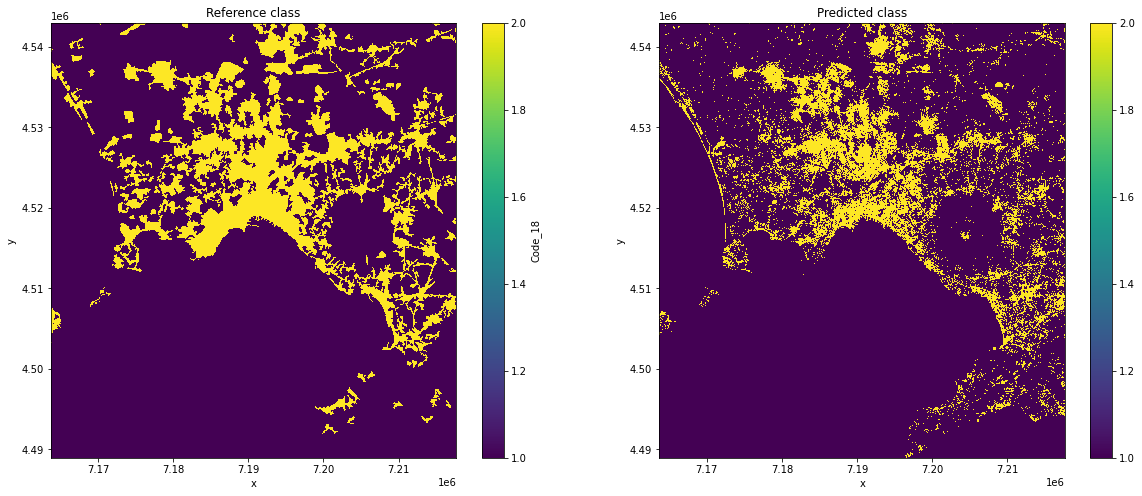

In [27]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
urban.plot(ax=ax[0])
ax[0].set_title('Reference class')
pred_logistic.plot(ax=ax[1])
ax[1].set_title('Predicted class');

## Model evaluation

We always want to assess the accuracy/goodness of a classifier to quantify how well it is doing,
and to be able to compare it to other classifiers and chose the best one.

There is no single accuracy metric that is appropriate in every case.

- precision
- recall
- overall accuracy

In addition, 
we often want a model that is as simple as possible (both to avoid overfitting and to aid interpretability)
and so it is common to penalise the model complexity in some way.

To get a sense of the number of possible scoring metrics,
have a look at the `scikit-learn` page on the topic:
https://scikit-learn.org/stable/modules/model_evaluation.html

In [28]:
from sklearn import metrics

Let us first compute the simple accuracy score manually.
This is the fraction of correctly classified data points:

In [29]:
(pred_logistic == urban).mean()

<xarray.DataArray ()>
array(0.9004108)

We could also compute the confusion matrix, and get the accuracy score this way:

In [30]:
C = metrics.confusion_matrix(urban.stack(z=('x', 'y')), pred_logistic.stack(z=('x', 'y')))

In [31]:
C

array([[2590345,   95304],
       [ 227365,  326986]])

In [32]:
C.diagonal().sum() / C.sum()

0.9004108024691359

However, the easiest way is to use the functions implemented in `sklearn.metrics`, which also includes many other scoring methods:

In [33]:
logistic.score(data, urban)

0.9004108024691359

For example, the recall can be calculated as:

In [34]:
logistic.score(data, urban, method='recall')

0.9645136054637072

This means that 96.7% of non-urban areas are correctly identified.

The recall can also be computed manually:

In [35]:
(pred_logistic == urban).where(urban==1).mean()

<xarray.DataArray ()>
array(0.96451361)

### Comparing the classifiers

Decision tree:

In [36]:
tree.score(data, urban)

0.8457753086419753

In [37]:
tree.score(data, train1)

0.9984625

The score for the training data set is much higher than for the whole data set. This is a clear indicator for overfitting.

Logistic regression:

In [38]:
logistic.score(data, urban)

0.9004108024691359

In [39]:
logistic.score(data, train2)

0.8967

For this classifier, the score for the training data set is about the same as the score for the whole data set. There is no overfitting.

## Tuning a classifier

Most classifiers have a number of parameters that can be adjusted (tuned) to suit many different cases.
Finding the best combination of parameters is often a mix of experience/intuition and trial and error,
but there are systematic methods for doing this.

Firstly, model evaluation is always done on a dataset that was *not* used for training,
to prevent overfitting.
A systematic approach to this is $k$-fold cross-validation,
which splits the data into $k$ equal chunks,
and then iteratively trains the model on one of the chunks while using the remaining $k-1$ chunks for testing.
The cross-validation score is then the mean of the test scores of all splits.

When tuning a classifier,
we want to know the cross-validation score for each combination of parameters
so we can select the best performing model.

Luckily, `scikit-learn` has a built-in method for this: `GridSearchCV`

**Warning**: When the parameter grid is too large, this can quickly become very computationally expensive!

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
_clf = Pipeline(steps=[
    ('scaling', StandardScaler()),
    ('logistic', LogisticRegression(max_iter=300))
])
# When using a Pipeline, we need to add the name of the corresponding pipeline step as a prefix,
# followed by a double underscore (__):
parameters = {
    'logistic__C': np.logspace(-3, 1, 15)
}
clf = GridSearchCV(_clf, parameters)
logistic_grid = nd.classify.Classifier(clf)

In [42]:
mask = sample(urban.shape, N=50_000)
truth = urban.where(mask)

In [43]:
%time logistic_grid.fit(data, truth)

CPU times: user 5min, sys: 8.64 s, total: 5min 9s
Wall time: 27.9 s


Let us look at how the regularization parameter affects the score:

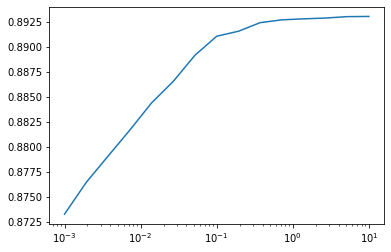

In [44]:
results = logistic_grid.clf.cv_results_
C = results['param_logistic__C'].data
score = results['mean_test_score']
fig, ax = plt.subplots(1, 1)
ax.plot(C, score)
ax.set_xscale('log')

We can extract the optimum parameters:

In [45]:
logistic_grid.clf.best_params_

{'logistic__C': 10.0}

And the optimum score:

In [46]:
logistic_grid.clf.best_score_

0.8930400000000001

In [47]:
%time pred_logistic_grid = logistic_grid.predict(data).transpose('y', 'x')

CPU times: user 3.33 s, sys: 612 ms, total: 3.94 s
Wall time: 2.05 s


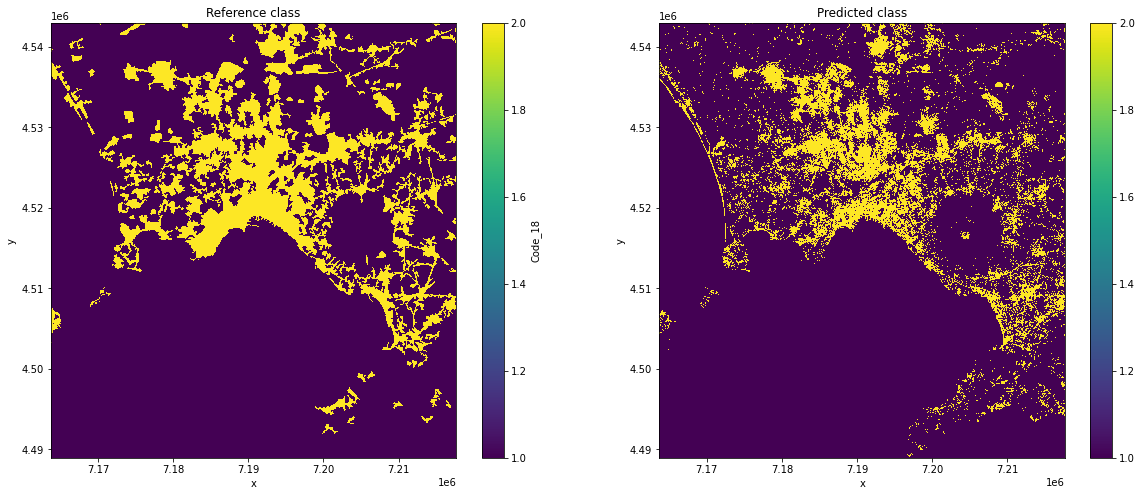

In [48]:
# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
urban.plot(ax=ax[0])
ax[0].set_title('Reference class')
pred_logistic_grid.plot(ax=ax[1])
ax[1].set_title('Predicted class');

## Feature importance

For most classifiers,
we can extract some measure of feature importance to find out which features contribute the most
to the classification outcome.

For the logistic regressions, we can simply extract the coefficients:

In [49]:
estimator = logistic_grid.clf.best_estimator_['logistic']
features = pd.Series(dict(zip(data.variables, estimator.coef_[0]))).sort_values(ascending=False)
features

B12               4.578004
B4                2.549886
B6                2.154141
B8                1.495353
B1                1.007137
VH_asc_spring     0.778489
VH_desc_spring    0.531374
VH_desc_summer    0.525674
VH_asc_autumn     0.488692
VV_desc_winter    0.243782
VV_asc_spring     0.152312
VV_desc_autumn    0.120702
VV_asc_winter     0.015589
VH_desc_winter   -0.023563
VV_desc_summer   -0.043260
B5               -0.048204
VV_asc_autumn    -0.072736
VH_asc_summer    -0.094920
VV_asc_summer    -0.118647
VV_desc_spring   -0.252468
VH_desc_autumn   -0.381098
VH_asc_winter    -0.614058
B3               -1.216836
B2               -1.671803
B7               -2.149175
B11              -5.031923
dtype: float64

We can even create an image based on the top three features.
In theory, this should be the representation of three variables that is maximising contrast btween urban and non-urban areas.

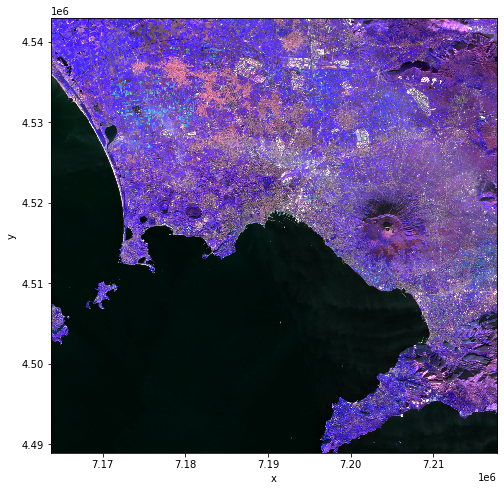

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
img = data[features[:3].keys()].to_array('rgb')
img.plot.imshow(rgb='rgb', robust=True)

## Multi-class Classification

Let us know briefly look at multi-class classification.
Some classifiers can support multiple labels out of the box (e.g. decision trees),
while other classifiers can be generalised to multiple classes using a one-vs-the-rest approach (e.g. logistic regression).

More information: https://scikit-learn.org/stable/modules/multiclass.html

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

Let's train a random forest classifier.
Note that I am not specifying any parameters to optimise so the `GridSearchCV` is not actually doing anything,
but I'm still using it here for good practice.
It also allows us to access the CV score.

In [52]:
_c = Pipeline(steps=[
    ('pca', PCA(n_components=10)),
    ('forest', RandomForestClassifier(n_estimators=100, max_depth=10))
])
clf = nd.classify.Classifier(GridSearchCV(_c, {}, n_jobs=-1))

In [53]:
mask = sample(labels.shape, N=20_000)
train = labels.where(mask)

In [54]:
%time clf.fit(data, train)

/Users/jhansen/anaconda3/envs/sense4/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CPU times: user 7.63 s, sys: 562 ms, total: 8.2 s
Wall time: 11.5 s


In [55]:
%time pred = clf.predict(data).transpose('y', 'x')

CPU times: user 1min 6s, sys: 24.5 s, total: 1min 31s
Wall time: 1min 28s


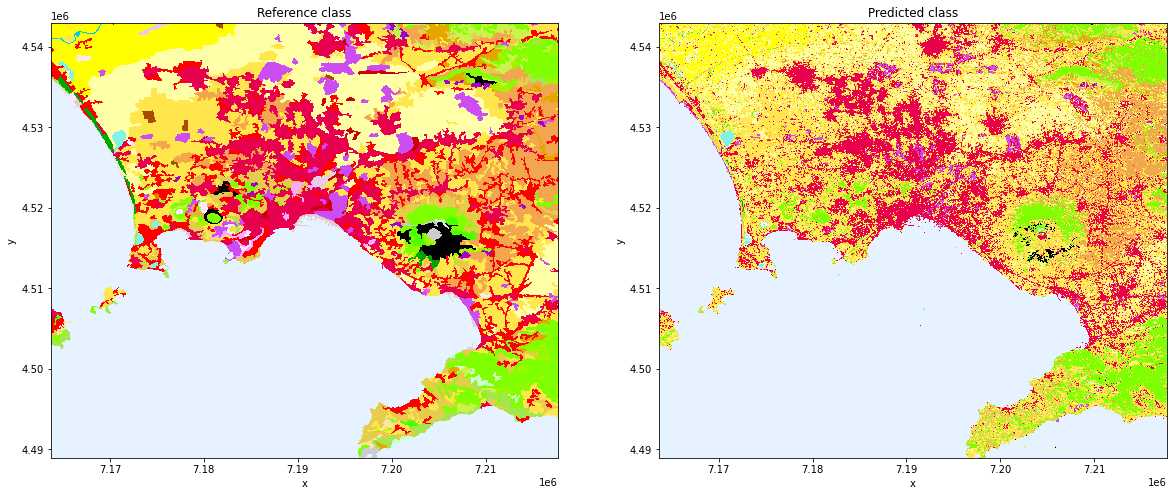

In [56]:
rgb_true = make_rgb(labels)
rgb_pred = make_rgb(pred)

# Create 1x2 subplot grid
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
rgb_true.plot.imshow(rgb='rgb', ax=ax[0])
ax[0].set_title('Reference class')
rgb_pred.plot.imshow(rgb='rgb', ax=ax[1])
ax[1].set_title('Predicted class');

---
# Your turn!

Please use the remainder of the workshop to explore the data and try out different classification algorithms.
Here are some ideas for things you can try:

- Group the class labels into a few different groups (e.g. forest, agriculture, urban, water)

- Try other classifiers, e.g.
    - SVM (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
    - Random Forest (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- Try using *only* the radar data or *only* the optical data — which performs best?

- Explore unsupervised methods (clustering)